# PACKAGE

In [1]:
import scipy.io
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, add, LSTM, Dense, Dropout,GRU
from tensorflow.keras.backend import clear_session

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from scipy.io import loadmat

tf.random.set_seed(42)
np.random.seed(42)

C:\Users\vulv2\AppData\Local\Temp\ipykernel_14864\168337178.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# D2A

In [2]:
def displacement_to_acceleration(displacement, dt):
    """
    Calculate acceleration from an array of displacement values over time.
    
    Parameters:
    - displacement: A NumPy array of displacement values.
    - dt: The time step between measurements.
    
    Returns:
    - A NumPy array of acceleration values, with the same size as the input array by padding.
    """
    # First derivative (Velocity)
    velocity = np.diff(displacement) / dt

    # Second derivative (Acceleration)
    acceleration = np.diff(velocity) / dt

    # Padding the acceleration array with zeros at the beginning and the end
    # to maintain the same size as the original displacement array.
    acceleration_padded = np.pad(acceleration, (1, 1), 'constant', constant_values=(0, 0))

    return acceleration

In [4]:
disp = np.load('data.npy')

# Tạo noise
acc = np.zeros([disp.shape[0],disp.shape[1],24998])
for i in range(disp.shape[0]):
    for j in range(disp.shape[1]):
        disp[i,j,:] = disp[i,j,:] + np.random.randn(disp.shape[2])*max(disp[i,j,:])/2000
        acc[i,j,:] = displacement_to_acceleration(disp[i,j,:],0.01)
disp.shape

(15, 32, 25000)

In [5]:
acc_new = acc[:,:,998:]
acc_new

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [6]:
acc_new.shape

(15, 32, 24000)

In [7]:
output_labels = np.linspace(0,7,8)
output_labels

array([0., 1., 2., 3., 4., 5., 6., 7.])

(32, 24000)


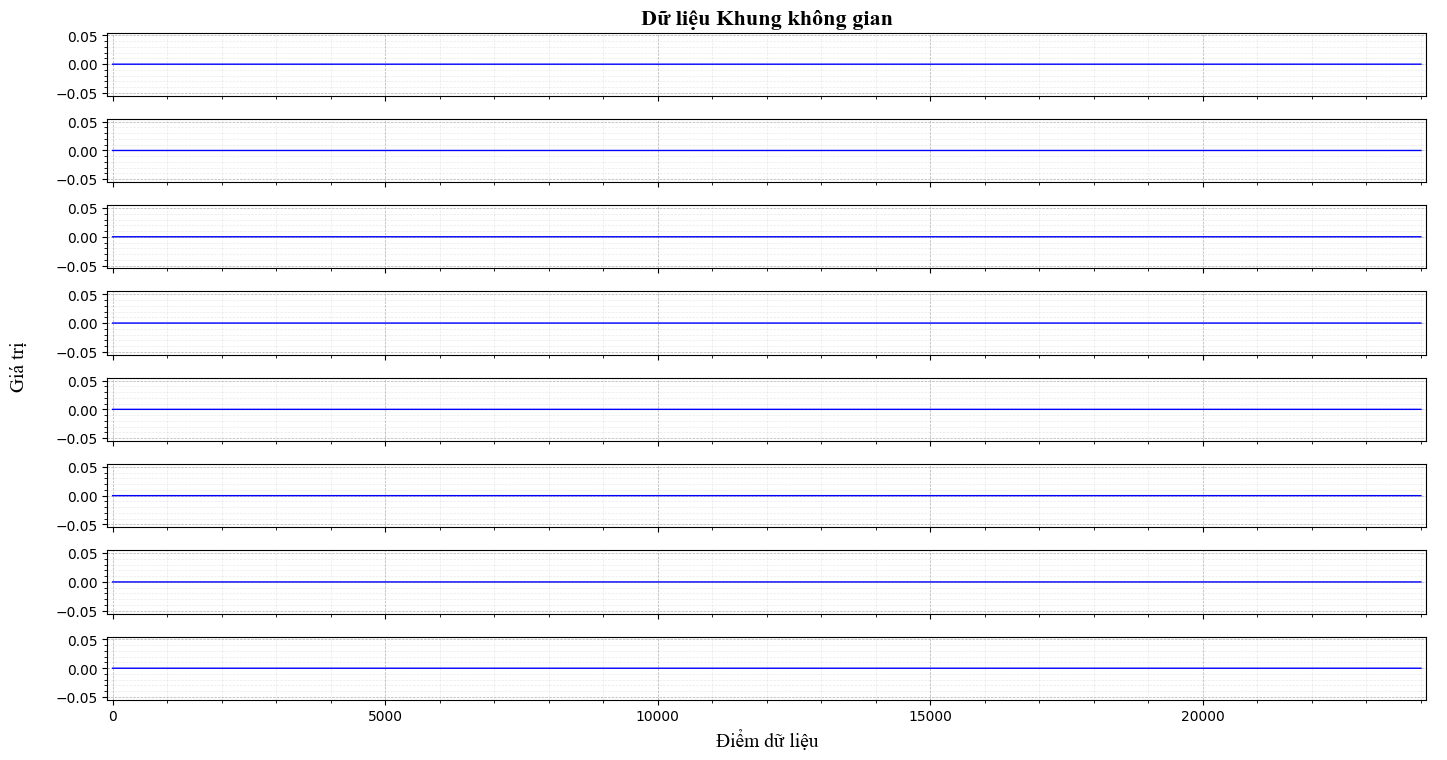

In [8]:
input_data = acc_new
Data = input_data[2,:, :]
print(Data.shape)
# Create the plot
fig, axes = plt.subplots(8, 1, figsize=(15, 8), sharex=True)

title_font = {'family': 'Times New Roman', 'size': 16, 'weight': 'bold'}
label_font = {'family': 'Times New Roman', 'size': 14}
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.family'] = 'sans-serif'

# Plot the data for each sub-array
for i, ax in enumerate(axes):
    ax.plot(Data[i, :], linewidth=1, color = 'b')
    # ax.set_title(f'Z24 Signal Data at Index (1, {i}, :)', fontsize=12)
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.minorticks_on()
    ax.grid(True, which='minor', color='#999999', linestyle='--', alpha=0.2)
    ax.set_xlim(-100, Data.shape[1]+100)
# Set common labels using axes
axes[-1].set_xlabel('Điểm dữ liệu', fontsize=14, fontdict=label_font)
axes[0].set_title('Dữ liệu Khung không gian', fontsize=16, fontdict=title_font)

# Create a "super" axis for the common Y-label and make it invisible
super_ax = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
super_ax.set_ylabel("Giá trị", fontsize=14, labelpad=15, fontdict=label_font)

# Move the super axis ylabel to avoid overlap with subplots
super_ax.yaxis.set_label_coords(-0.06,0.5)

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.show()

In [27]:
def check_for_different_shapes(arrays):
    """
    Kiểm tra xem các mảng trong danh sách có kích thước không đồng nhất không.

    Parameters:
        arrays (list): Danh sách các mảng NumPy.

    Returns:
        list: Danh sách các mảng không đồng nhất.
    """
    inhomogeneous_arrays = []
    expected_shape = None
    for array in arrays:
        if expected_shape is None:
            expected_shape = array.shape
        elif array.shape != expected_shape:
            inhomogeneous_arrays.append(array)
    return inhomogeneous_arrays

def augment_time_series_data(input_data, labels, num_augmentations=5):
    """
    Augment time series data.

    :param input_data: Original time series data array.
    :param labels: Corresponding labels for the data.
    :param num_augmentations: Number of augmented samples to generate per original sample.

    :return: Augmented data array and corresponding labels.
    """
    augmented_data = []
    augmented_labels = []

    num_samples, num_channels, sequence_length = input_data.shape

    for i in range(num_samples):
        for _ in range(num_augmentations):
            # Choose a random augmentation technique
            augmentation_type = random.choices(['noise', 'reverse', 'crop_pad', 'time_warp', 'random_shift'],
                                               weights=[0.6, 0.1, 0.1, 0.1, 0.1])[0]

            if augmentation_type == 'noise':
                # Add random noise
                # noise = np.random.normal(0, 0.15, input_data[i].shape)
                augmented_sample = input_data[i] + np.random.normal(0, np.max(input_data[i])/10, input_data[i].shape)

            elif augmentation_type == 'reverse':
                # Reverse the sequence
                augmented_sample = np.flip(input_data[i], axis=-1)

            elif augmentation_type == 'crop_pad':
                # Crop and pad the sequence
                crop_size = random.randint(1, sequence_length // 100)
                padded_sample = np.pad(input_data[i], ((0, 0), (crop_size, 0)), mode='constant', constant_values=0)
                augmented_sample = padded_sample[:, :-crop_size]

            elif augmentation_type == 'time_warp':
                # Time warping
                start_idx = random.randint(0, sequence_length // 2)
                end_idx = random.randint(start_idx, sequence_length)
                warped_segment = np.mean(input_data[i][:, start_idx:end_idx], axis=1, keepdims=True)
                augmented_sample = np.concatenate((warped_segment, input_data[i][:, end_idx:]), axis=1)

            elif augmentation_type == 'random_shift':
                # Random shifting
                shift_amount = random.randint(-(sequence_length // 10), sequence_length // 10)
                augmented_sample = np.roll(input_data[i], shift_amount, axis=-1)

            if augmented_sample.shape == (num_channels, sequence_length):
                augmented_data.append(augmented_sample)
                augmented_labels.append(labels[i])
            else:
                print("Invalid shape:", augmented_sample.shape)

    # Convert to numpy arrays
    # Sử dụng hàm
    inhomogeneous_arrays = check_for_different_shapes(augmented_data)
    if inhomogeneous_arrays:
        print("Các mảng không đồng nhất:")
        for array in inhomogeneous_arrays:
            print(array.shape)
    else:
        print("Tất cả các mảng có kích thước giống nhau.")

    return np.array(augmented_data), np.array(augmented_labels)

# Sử dụng hàm
augmented_data, augmented_labels = augment_time_series_data(input_data, output_labels, num_augmentations=100)
print(augmented_data.shape, augmented_labels.shape)

Invalid shape: (8, 499)
Invalid shape: (8, 3207)
Invalid shape: (8, 3480)
Invalid shape: (8, 936)
Invalid shape: (8, 1960)
Invalid shape: (8, 898)
Invalid shape: (8, 5976)
Invalid shape: (8, 6491)
Invalid shape: (8, 3698)
Invalid shape: (8, 1553)
Invalid shape: (8, 1270)
Invalid shape: (8, 535)
Invalid shape: (8, 34)
Invalid shape: (8, 4166)
Invalid shape: (8, 5218)
Invalid shape: (8, 4015)
Invalid shape: (8, 1424)
Invalid shape: (8, 4392)
Invalid shape: (8, 4772)
Invalid shape: (8, 1888)
Invalid shape: (8, 2853)
Invalid shape: (8, 4604)
Invalid shape: (8, 2025)
Invalid shape: (8, 354)
Invalid shape: (8, 26)
Invalid shape: (8, 3964)
Invalid shape: (8, 3705)
Invalid shape: (8, 1236)
Invalid shape: (8, 4937)
Invalid shape: (8, 3460)
Invalid shape: (8, 938)
Invalid shape: (8, 4887)
Invalid shape: (8, 6499)
Invalid shape: (8, 4079)
Invalid shape: (8, 1376)
Invalid shape: (8, 2218)
Invalid shape: (8, 3976)
Invalid shape: (8, 5230)
Invalid shape: (8, 3918)
Invalid shape: (8, 5593)
Invalid sh

(8, 8998)


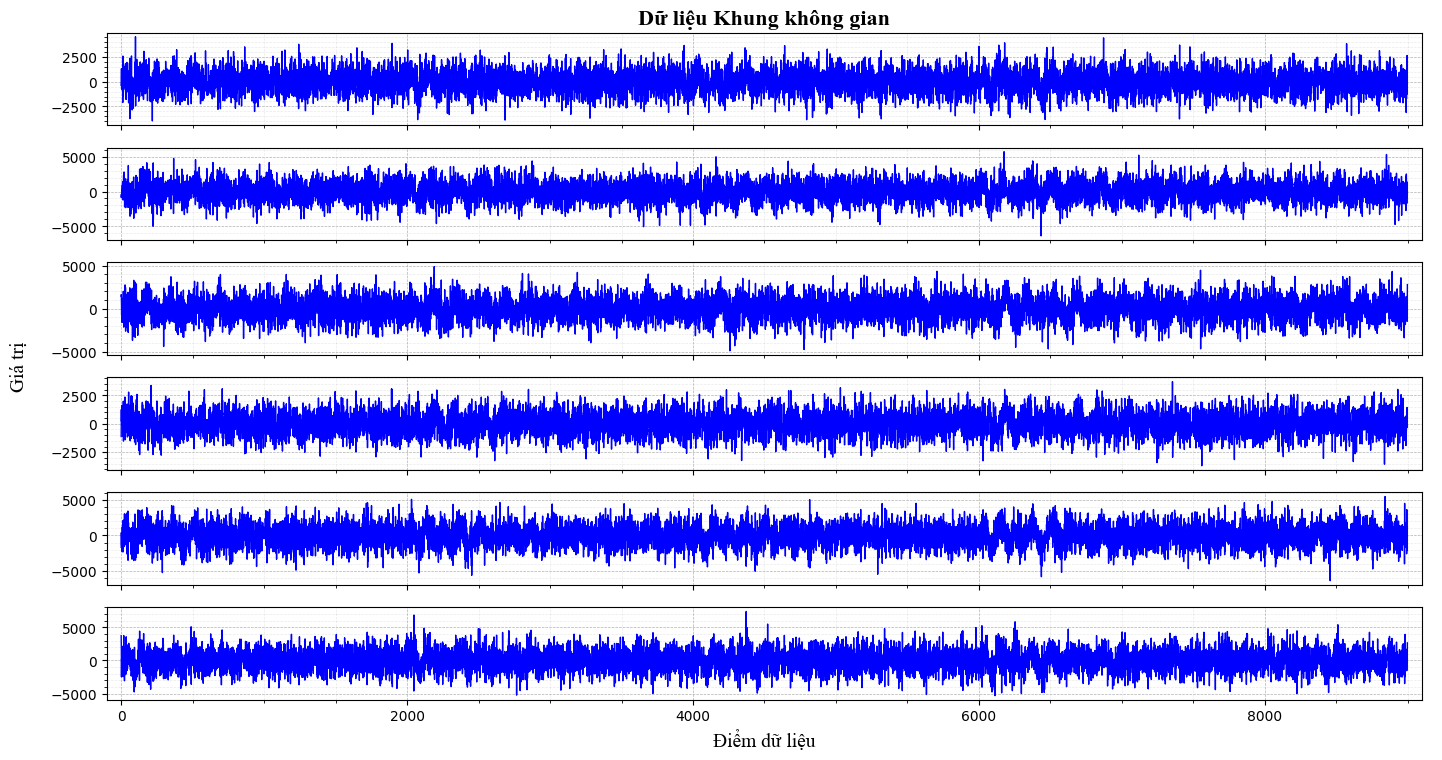

In [28]:

Data = augmented_data[0,:, :]
print(Data.shape)
# Create the plot
fig, axes = plt.subplots(6, 1, figsize=(15, 8), sharex=True)

title_font = {'family': 'Times New Roman', 'size': 16, 'weight': 'bold'}
label_font = {'family': 'Times New Roman', 'size': 14}
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.family'] = 'sans-serif'

# Plot the data for each sub-array
for i, ax in enumerate(axes):
    ax.plot(Data[i, :], linewidth=1, color = 'b')
    # ax.set_title(f'Z24 Signal Data at Index (1, {i}, :)', fontsize=12)
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.minorticks_on()
    ax.grid(True, which='minor', color='#999999', linestyle='--', alpha=0.2)
    ax.set_xlim(-100, Data.shape[1]+100)
# Set common labels using axes
axes[-1].set_xlabel('Điểm dữ liệu', fontsize=14, fontdict=label_font)
axes[0].set_title('Dữ liệu Khung không gian', fontsize=16, fontdict=title_font)

# Create a "super" axis for the common Y-label and make it invisible
super_ax = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
super_ax.set_ylabel("Giá trị", fontsize=14, labelpad=15, fontdict=label_font)

# Move the super axis ylabel to avoid overlap with subplots
super_ax.yaxis.set_label_coords(-0.06,0.5)

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.show()

In [29]:
# input_train = reshaped_data
# output_train = reshaped_labels

input_train = augmented_data
output_train = augmented_labels

X_train, X_temp, y_train, y_temp = train_test_split(input_train, output_train, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("X_train's shape:" + str(X_train.shape))
print("y_train's shape:" + str(y_train.shape))
print("X_test's shape:" + str(X_test.shape))
print("y_test's shape:" + str(y_test.shape))
print("X_val's shape:" + str(X_valid.shape))
print("y_val's shape:" + str(y_valid.shape))

X_train's shape:(326, 8, 8998)
y_train's shape:(326,)
X_test's shape:(109, 8, 8998)
y_test's shape:(109,)
X_val's shape:(109, 8, 8998)
y_val's shape:(109,)


In [30]:
label=np.unique(y_train)
print('Label = ' + str(label))
num_classes = len(np.unique(y_train))
print('No. Labels: ' + str(num_classes))

Label = [0. 1. 2. 3. 4. 5.]
No. Labels: 6


# LSTM

In [31]:
clear_session()

def build_LSTM_model(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)    
    x = LSTM(512, return_sequences=True)(input_tensor)  
    x = LSTM(128, return_sequences=True,dropout=0.3)(x)  
    x = LSTM(128, return_sequences=True,dropout=0.3)(x)  
    x = Flatten()(x)
    x = Dense(128)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Run the model on GPU if available
with tf.device('/GPU:0'):
    LSTM_model = build_LSTM_model((X_train.shape[1], X_train.shape[2]), num_classes)  # Adjusted input shape to have 3 dimensions
    
    LSTM_model.summary()

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True)

    # Train the model
    history_LSTM = LSTM_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 8998)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm (LSTM)                     │ (None, 8, 512)            │ 19,478,528 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_1 (LSTM)                   │ (None, 8, 128)            │    328,192 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_2 (LSTM)                   │ (None, 8, 128)            │    131,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 1024)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    131,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 6)                 │        774 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 20,070,278 (76.56 MB)

 Trainable params: 20,070,278 (76.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.3994 - loss: 1.6339 - val_accuracy: 0.7798 - val_loss: 0.9447
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.8208 - loss: 0.6558 - val_accuracy: 0.7982 - val_loss: 0.5099
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.8988 - loss: 0.3374 - val_accuracy: 0.7982 - val_loss: 0.6203
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.9088 - loss: 0.2576 - val_accuracy: 0.8073 - val_loss: 0.6296
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.9607 - loss: 0.1709 - val_accuracy: 0.8440 - val_loss: 0.5990
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.9548 - loss: 0.1102 - val_accuracy: 0.8257 - val_loss: 0.6766
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.9432 - loss: 0.1890 - val_accuracy: 0.8257 - val_loss: 0.9309
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.9692 - loss: 0.1159 - val_accuracy: 0.

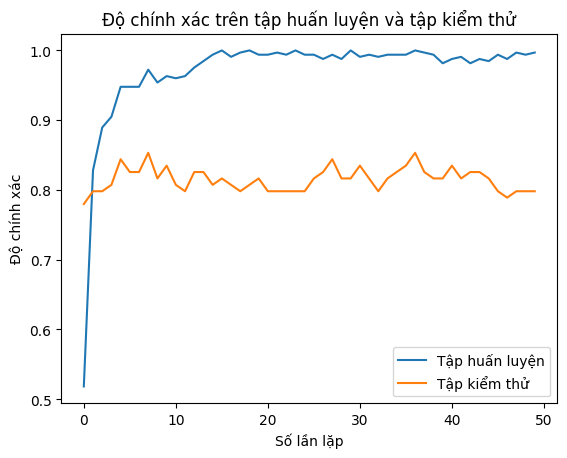

--------------Test set----------------


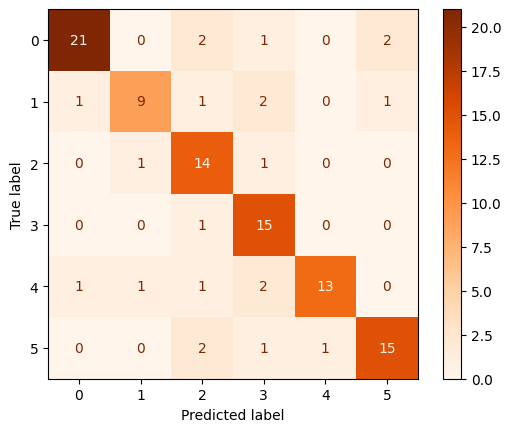

,precision,recall,f1-score,support
0.0,0.913,0.808,0.857,26.000
1.0,0.818,0.643,0.720,14.000
2.0,0.667,0.875,0.757,16.000
3.0,0.682,0.938,0.789,16.000
4.0,0.929,0.722,0.813,18.000
5.0,0.833,0.789,0.811,19.000
accuracy,0.798,0.798,0.798,0.798
macro avg,0.807,0.796,0.791,109.000
weighted avg,0.819,0.798,0.799,109.000


--------------validate----------------


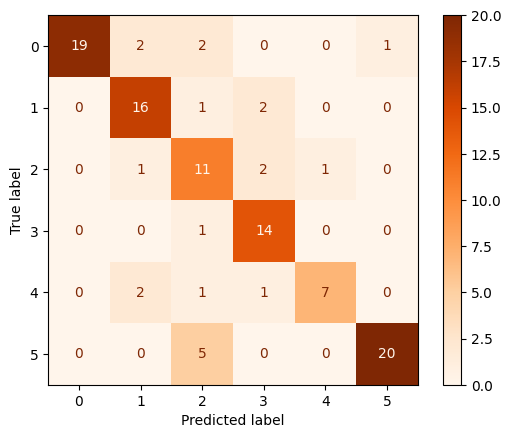

,precision,recall,f1-score,support
0.0,1.000,0.792,0.884,24.000
1.0,0.762,0.842,0.800,19.000
2.0,0.524,0.733,0.611,15.000
3.0,0.737,0.933,0.824,15.000
4.0,0.875,0.636,0.737,11.000
5.0,0.952,0.800,0.870,25.000
accuracy,0.798,0.798,0.798,0.798
macro avg,0.808,0.789,0.787,109.000
weighted avg,0.833,0.798,0.805,109.000


----------------train----------------


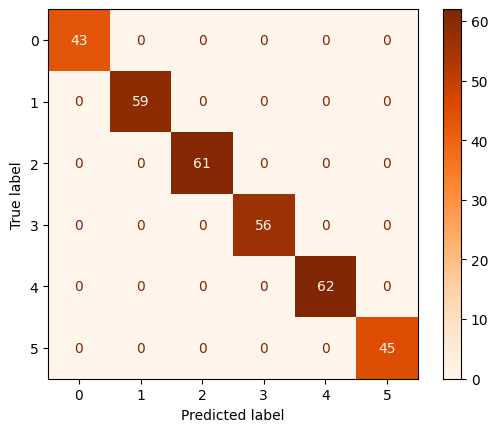

,precision,recall,f1-score,support
0.0,1.0,1.0,1.0,43.0
1.0,1.0,1.0,1.0,59.0
2.0,1.0,1.0,1.0,61.0
3.0,1.0,1.0,1.0,56.0
4.0,1.0,1.0,1.0,62.0
5.0,1.0,1.0,1.0,45.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,326.0
weighted avg,1.0,1.0,1.0,326.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7953 - loss: 1.4180
Final model has loss of test set is: 1.4865509271621704 and accuracy is: 0.7981651425361633
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7953 - loss: 1.4961
Final model has loss of validation set is: 1.3562066555023193 and accuracy is: 0.7981651425361633


In [32]:
LSTM_acc = history_LSTM.history['accuracy']
LSTM_val = history_LSTM.history['val_accuracy']
plt.figure()
plt.plot(history_LSTM.history['accuracy'], label='Tập huấn luyện')
plt.plot(history_LSTM.history['val_accuracy'], label='Tập kiểm thử')
plt.xlabel('Số lần lặp')
plt.ylabel('Độ chính xác')
plt.title("Độ chính xác trên tập huấn luyện và tập kiểm thử")
plt.legend()
plt.show()

display(HTML('<hr>'))
print("--------------Test set----------------")
# check test set
y_pred = LSTM_model.predict(X_test,verbose = 0)
y_pred_bool = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
report = classification_report(y_test, y_pred_bool,labels=label, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.round(3))

display(HTML('<hr>'))

print("--------------validate----------------")
# check validate set
y_pred = LSTM_model.predict(X_valid,verbose = 0)
y_pred_bool = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_valid, y_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
report = classification_report(y_valid, y_pred_bool,labels=label, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.round(3))

display(HTML('<hr>'))
# check train set
print("----------------train----------------")
y_pred = LSTM_model.predict(X_train,verbose = 0)
y_pred_bool = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_train, y_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
report = classification_report(y_train, y_pred_bool,labels=label, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.round(3))

# Final result
test_loss_LSTM, test_acc_LSTM = LSTM_model.evaluate(X_test, y_test)
print('Final model has loss of test set is: {} and accuracy is: {}'.format(test_loss_LSTM,test_acc_LSTM))
val_loss_LSTM, val_acc_LSTM = LSTM_model.evaluate(X_valid, y_valid)
print('Final model has loss of validation set is: {} and accuracy is: {}'.format(val_loss_LSTM,val_acc_LSTM))

# 1DCNN

In [35]:
clear_session()

def build_1DCNN_model(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)
    
    # 1D-CNN Preprocessing Layers
    x = Conv1D(filters=256, kernel_size=1, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = MaxPool1D()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=128, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=64, kernel_size=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Dense Layers for Classification
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Run the model on GPU if available
with tf.device('/GPU:0'):
    DCNN_model = build_1DCNN_model((X_train.shape[1], X_train.shape[2]), num_classes)  # Adjusted input shape to have 3 dimensions
    DCNN_model.summary()

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

    # Train the model
    history_1DCNN = DCNN_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_valid, y_valid))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 11, 10000)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d (Conv1D)                 │ (None, 11, 256)           │  2,560,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 11, 256)           │      1,024 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 256)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation (Activation)         │ (None, 5, 256)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 128)            │     98,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 5, 128)            │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_1 (Activation)       │ (None, 5, 128)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 64)             │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 5, 64)             │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_2 (Activation)       │ (None, 5, 64)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 320)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │     41,088 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,711,114 (10.34 MB)

 Trainable params: 2,710,218 (10.34 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.1116 - loss: 2.5789 - val_accuracy: 0.0778 - val_loss: 3.7996
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.1515 - loss: 2.2874 - val_accuracy: 0.0889 - val_loss: 2.8744
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.2781 - loss: 2.1166 - val_accuracy: 0.0833 - val_loss: 2.7298
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4881 - loss: 1.8041 - val_accuracy: 0.1000 - val_loss: 2.4479
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.6977 - loss: 1.2045 - val_accuracy: 0.1444 - val_loss: 2.6070
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7291 - loss: 0.8251 - val_accuracy: 0.1000 - val_loss: 2.7789
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7487 - loss: 0.7610 - val_accuracy: 0.1278 - val_loss: 2.6348
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7482 - loss: 0.7106 - val_accuracy: 0.

KeyboardInterrupt: 

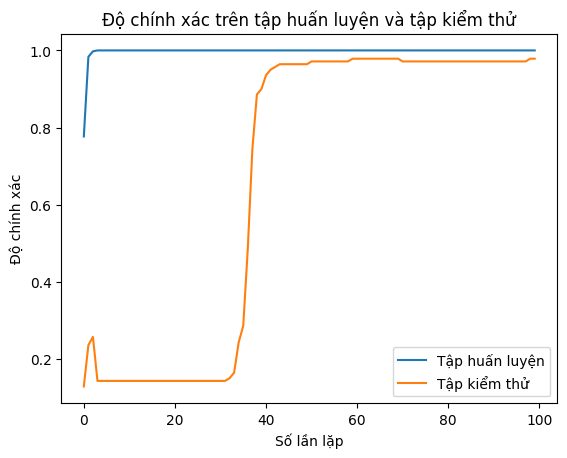

--------------Test set----------------


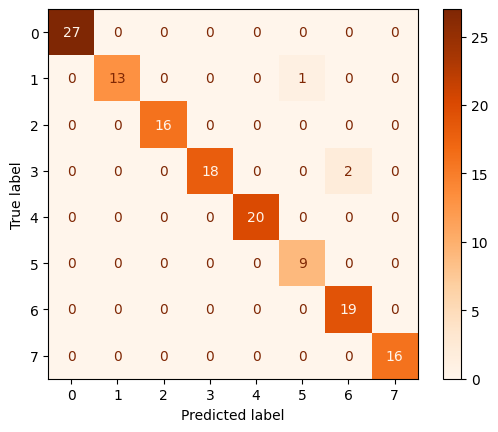

,precision,recall,f1-score,support
0.0,1.000,1.000,1.000,27.000
1.0,1.000,0.929,0.963,14.000
2.0,1.000,1.000,1.000,16.000
3.0,1.000,0.900,0.947,20.000
4.0,1.000,1.000,1.000,20.000
5.0,0.900,1.000,0.947,9.000
6.0,0.905,1.000,0.950,19.000
7.0,1.000,1.000,1.000,16.000
accuracy,0.979,0.979,0.979,0.979
macro avg,0.976,0.979,0.976,141.000


--------------validate----------------


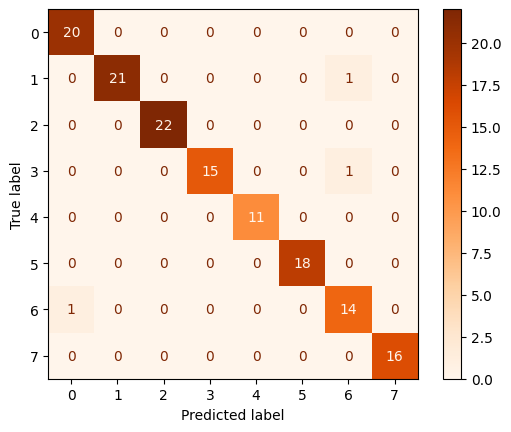

,precision,recall,f1-score,support
0.0,0.952,1.000,0.976,20.000
1.0,1.000,0.955,0.977,22.000
2.0,1.000,1.000,1.000,22.000
3.0,1.000,0.938,0.968,16.000
4.0,1.000,1.000,1.000,11.000
5.0,1.000,1.000,1.000,18.000
6.0,0.875,0.933,0.903,15.000
7.0,1.000,1.000,1.000,16.000
accuracy,0.979,0.979,0.979,0.979
macro avg,0.978,0.978,0.978,140.000


----------------train----------------


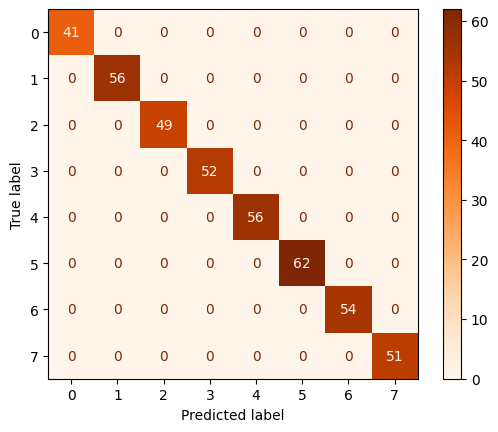

,precision,recall,f1-score,support
0.0,1.0,1.0,1.0,41.0
1.0,1.0,1.0,1.0,56.0
2.0,1.0,1.0,1.0,49.0
3.0,1.0,1.0,1.0,52.0
4.0,1.0,1.0,1.0,56.0
5.0,1.0,1.0,1.0,62.0
6.0,1.0,1.0,1.0,54.0
7.0,1.0,1.0,1.0,51.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,421.0


5/5 [==============================] - 0s 12ms/step - loss: 0.0814 - accuracy: 0.9787
Final model has loss of test set is: 0.08139663934707642 and accuracy is: 0.978723406791687
5/5 [==============================] - 0s 11ms/step - loss: 0.0874 - accuracy: 0.9786
Final model has loss of validation set is: 0.08738114684820175 and accuracy is: 0.9785714149475098


In [21]:
DCNN_acc = history_1DCNN.history['accuracy']
DCNN_val = history_1DCNN.history['val_accuracy']
plt.figure()
plt.plot(history_1DCNN.history['accuracy'], label='Tập huấn luyện')
plt.plot(history_1DCNN.history['val_accuracy'], label='Tập kiểm thử')
plt.xlabel('Số lần lặp')
plt.ylabel('Độ chính xác')
plt.title("Độ chính xác trên tập huấn luyện và tập kiểm thử")
plt.legend()
plt.show()

display(HTML('<hr>'))
print("--------------Test set----------------")
# check test set
y_pred = DCNN_model.predict(X_test,verbose = 0)
y_pred_bool = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
report = classification_report(y_test, y_pred_bool,labels=label, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.round(3))

display(HTML('<hr>'))

print("--------------validate----------------")
# check validate set
y_pred = DCNN_model.predict(X_valid,verbose = 0)
y_pred_bool = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_valid, y_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
report = classification_report(y_valid, y_pred_bool,labels=label, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.round(3))

display(HTML('<hr>'))
# check train set
print("----------------train----------------")
y_pred = DCNN_model.predict(X_train,verbose = 0)
y_pred_bool = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_train, y_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Oranges)
plt.show()
report = classification_report(y_train, y_pred_bool,labels=label, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.round(3))

# Final result
test_loss_1DCNN, test_acc_1DCNN = DCNN_model.evaluate(X_test, y_test)
print('Final model has loss of test set is: {} and accuracy is: {}'.format(test_loss_1DCNN,test_acc_1DCNN))
val_loss_1DCNN, val_acc_1DCNN = DCNN_model.evaluate(X_valid, y_valid)
print('Final model has loss of validation set is: {} and accuracy is: {}'.format(val_loss_1DCNN,val_acc_1DCNN))